In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import itertools
from collections import defaultdict
from collections import Counter
import io
import gurobipy as gp
from gurobipy import GRB
from itertools import combinations
from itertools import groupby
from random import sample
import math
import json
import random
import os
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['Computer Modern Roman'],
})
%matplotlib ipympl

In [2]:
def gen_sols(n,m,quer_dict,partial_dict,noise,n_sols):
    """ builds ILP to construct candidate database, based on answers to queries 
    Assumes bound on noise, n and m is known. """
    M = gp.Model()
    M.Params.OutputFlag = 0
    
    # Initialize the decision variables
    x = np.array([[M.addVar(vtype='B', name=f"x_{i}_{j}") 
                   for j in range(m)] for i in range(n)])
    # print(x)
    
    #adding the constraints...
    quer_cons(M,x,n,quer_dict,noise)
    partial_cons(M,x,n,partial_dict)
            
    # for i in range(n-1):
    #     M.addConstr(binatodeci(x[i]) <= binatodeci(x[i+1]))
    bin_cons(M,x,n)

    # Parameters
    M.Params.PoolSearchMode = 2
    M.Params.PoolSolutions = n_sols
    # m.Params.PoolSolutions = 2
    M.Params.PoolGap = 0.0

    # Optimize
    M.optimize()
    
    # print(f"Took {M.Runtime:.2f} seconds to solve")
    
    if M.solCount == 0:
        print("infeasible")
    
    out_lst = []
    for k in range(M.SolCount):
        M.Params.SolutionNumber = k
        out_x = np.zeros_like(x)
        for i in range(len(x)):
            for j in range(len(x[0])):
                out_x[i][j] = x[i][j].Xn
        # print([var.Xn for var in m.getVars()])
        out_lst.append(out_x)
        
    return out_lst, M.Runtime

def quer_cons(M,x,n,quer_dict,noise):
    """ Adds the constraints based on the queries in quer_dict"""
    
    y_var_dict = defaultdict()
    y_p_var_dict = defaultdict()
    y_n_var_dict = defaultdict()
    
    for quer in quer_dict.keys():
        y_var_dict[quer] = []
        y_p_var_dict[quer] = []
        y_n_var_dict[quer] = []
        
        positions_0 = []
        positions_1 = []
        for i, j in zip(quer[0],quer[1]):
            if j == 0: 
                positions_0.append(i)
            elif j ==1:
                positions_1.append(i)
        for i in range(n):
            y_var_dict[quer].append(M.addVar(vtype='B', name=f"y_{quer}_{i}"))
            y_p_var_dict[quer].append(M.addVar(vtype='B', name=f"y_p_{quer}_{i}"))
            y_n_var_dict[quer].append(M.addVar(vtype='B', name=f"y_n_{quer}_{i}"))
            
            M.addConstr( len(quer[0])*y_var_dict[quer][i] + (len(quer[0])+0.5)*y_p_var_dict[quer][i] <= 
                        sum([x[i][j] for j in positions_1]) + sum([(1-x[i][j]) for j in positions_0]))
            M.addConstr( (len(quer[0])-0.5)*y_n_var_dict[quer][i] + len(quer[0])*y_var_dict[quer][i] + 
                        m*y_p_var_dict[quer][i] >= 
                        sum([x[i][j] for j in positions_1])+ sum([(1-x[i][j]) for j in positions_0]))
            M.addConstr( y_var_dict[quer][i] + y_p_var_dict[quer][i] + y_n_var_dict[quer][i] == 1)
            
        if noise == 0:
            M.addConstr(sum(y_var_dict[quer]) == quer_dict[quer])
        else:
            M.addConstr(sum(y_var_dict[quer]) <= quer_dict[quer] + noise)
            M.addConstr(sum(y_var_dict[quer]) >= quer_dict[quer] - noise)
    return None

def partial_cons(M,x,n,partial_dict):
    """ Adds the constraints based on the partial information in partial_dict"""
    
    y_var_dict_partial = defaultdict()
    y_p_var_dict_partial = defaultdict()
    y_n_var_dict_partial = defaultdict()
    
    for quer in partial_dict.keys():
        y_var_dict_partial[quer] = []
        y_p_var_dict_partial[quer] = []
        y_n_var_dict_partial[quer] = []
        
        positions_0 = []
        positions_1 = []
        for i, j in zip(quer[0],quer[1]):
            if j == 0: 
                positions_0.append(i)
            elif j ==1:
                positions_1.append(i)
        for i in range(n):
            y_var_dict_partial[quer].append(M.addVar(vtype='B', name=f"y_partial_{quer}_{i}"))
            y_p_var_dict_partial[quer].append(M.addVar(vtype='B', name=f"y_p_partial_{quer}_{i}"))
            y_n_var_dict_partial[quer].append(M.addVar(vtype='B', name=f"y_n_partial_{quer}_{i}"))
            
            M.addConstr( len(quer[0])*y_var_dict_partial[quer][i] + (len(quer[0])+0.5)*y_p_var_dict_partial[quer][i] <= 
                        sum([x[i][j] for j in positions_1]) + sum([(1-x[i][j]) for j in positions_0]))
            M.addConstr( (len(quer[0])-0.5)*y_n_var_dict_partial[quer][i] + len(quer[0])*y_var_dict_partial[quer][i] + 
                        m*y_p_var_dict_partial[quer][i] >= 
                        sum([x[i][j] for j in positions_1])+ sum([(1-x[i][j]) for j in positions_0]))
            M.addConstr( y_var_dict_partial[quer][i] + y_p_var_dict_partial[quer][i] + y_n_var_dict_partial[quer][i] == 1)
            
        # this line does the work
        M.addConstr(sum(y_var_dict_partial[quer]) >= partial_dict[quer])
        
    return None

def bin_cons(M,x,n):
    """ Adds binary symmetry breaking constraint """
    for i in range(n-1):
        M.addConstr(binatodeci(x[i]) <= binatodeci(x[i+1]))
    return None

def gen_bin_data_set(n,m):
    """n is number of people, m is number of attributes used, database is uniform random"""
    db = pd.DataFrame(np.random.randint(0,2,size=(n, m)), columns=[f'att_{x}' for x in range(m)])
    return db

def gen_powerset(k):
    """ generates a powerset of k elements """
    out = []
    for i in itertools.product([0,1],repeat=k):
        out.append(i)
    return out

def gen_queries_uniform_complete(m,n_queries):
    """Generates all possible queries of m binary attributes, 
    takes a sample of size n_queries from the set"""
        
    queries = []
    for i in range(1,m+1):
        
        combs = itertools.combinations(range(m),i)
        for comb in combs:
            for choice in gen_powerset(i):
                quer = []
                quer.append(comb)
                quer.append(choice)
                queries.append(tuple(quer))
                
    return sample(queries,min(n_queries,len(queries)))

def gen_queries_all(m):
    """Generates all possible queries of m binary attributes"""
        
    queries = []
    for i in range(1,m+1):
        
        combs = itertools.combinations(range(m),i)
        for comb in combs:
            for choice in gen_powerset(i):
                quer = []
                quer.append(comb)
                quer.append(choice)
                queries.append(tuple(quer))
                
    return queries

def gen_queries_comp(m):
    """Generates all possible queries of m binary attributes, 
    takes a sample of size n_queries from the set"""
        
    queries = []
    for i in range(1,m+1):
        
        combs = itertools.combinations(range(m),i)
        for comb in combs:
            for choice in gen_powerset(i):
                quer = []
                quer.append(comb)
                quer.append(choice)
                queries.append(tuple(quer))
                
    return queries

def gen_queries_uniform(m,n_queries):
    """Generates random queries. Chooses number of attributes uniformly over [1,m],
    Would be interested to see how this changes with a skewed distribution, also
    would be interesting how it changes if symmetry in queries is forced"""
    
    queries = []

    for i in range(n_queries):
        quer = []
        atts = np.random.randint(1,m+1)
        quer.append(tuple(sorted(sample(range(m),atts))))
        quer.append(tuple(np.random.choice([0,1], size=[atts])))
        queries.append(quer)

    queries = list(set([tuple(x) for x in queries]))

    return queries

def gen_partial_info(db,n_part,m_part):
    """ generates a partial info dict based on n_partials rows
    and m_partials attributes per individual, if no partial info, we get None type """
    
    n = db.shape[0]
    m = db.shape[1]
    
    partial_dict = defaultdict(lambda:0)
    
    if n_part == 0 or m_part == 0:
        return partial_dict
    
    row_inds = np.random.choice(n,n_part, replace = False)
    for i in row_inds:
        att_sample = np.random.choice(m,m_part, replace = False)
        lst = []
        for j in att_sample:
            lst.append(int(db[i:i+1][f"att_{j}"]))
            
        # print(att_sample,lst)
        vals = [x for _,x in sorted(zip(att_sample,lst))]
        
        partial_dict[(tuple(sorted(att_sample)),tuple(vals))] += 1
    return partial_dict
            
def quer2string(query):
    """ converts query to a string to be used by pandas 'query' function"""
    string = ""
    for pos, att in enumerate(query[0]):
        string += f'att_{att} == {query[1][pos]} & '
    return string[0:-3]

def get_counts_uniform(db,quers,noise):
    """Returns noisy count of query, noise is uniform random integer over -noise to noise (inclusive). 
    Will perturb negative counts to 0."""
    out_dict = defaultdict(int)
    for query in quers:
        out_dict[tuple(query)] = max(len(db.query(quer2string(query))) + np.random.randint(-noise,noise+1),0)
    return out_dict

def binatodeci(binary):
    return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

def check_fixed_sols(sols):
    """Takes some candidate databases and returns which
    rows are contained in all of them, including duplicates"""
    
    if len(sols) == 1:
        return [tuple(x) for x in sols[0]]
    
    out_lst = []
    for sol in sols:
        temp = []
        for row in sol:
            temp.append(tuple(row))
        out_lst.append(temp)
    # print(out_lst)

    fixed_sols = []
    for row in out_lst[0]:
        count = 0
        for sol in out_lst[1:]:
            if row in sol:
                sol.remove(row)
                count += 1
            # else:
            #     break
        if count == len(sols) - 1:
            fixed_sols.append(row)
    return fixed_sols

def total_sim(sol,db):
    count = 0
    for i, val_i in enumerate(db):
        for j, val_j in enumerate(val_i):
            # print(val_j, sol[i][j])
            if val_j != sol[i][j]:
                count += 1
            
    return  1 - count/(len(db[0])*len(db))

def gen_cij(db,sol,i,j):
    """ computes cost of assigning row i of solution 
    to row j of database in terms of L1 norm"""
    
    cost = sum([abs(db[j][k]-sol[i][k]) for k in range(len(sol[0]))])
    return cost

def ass_ILP(db,sol):
    """ Creates an optimal assignment of rows in the solution 
    to the rows in the true database, the objective function value
    is returned and is the smallest number of differences between
    solution and true database, based on row swapping"""
    
    n = len(sol)
    M = gp.Model()
    M.Params.OutputFlag = 0
    
    x = np.array([[M.addVar(vtype='B', name=f"x_{i}_{j}") 
               for j in range(n)] for i in range(n)])
    
    for i in range(n):
        M.addConstr(sum(x[i,:]) == 1)
        M.addConstr(sum(x[:,i]) == 1)
        
    M.setObjective(sum([sum([x[i][j]*gen_cij(db,sol,i,j) for j in range(n)]) for i in range(n)]), GRB.MINIMIZE)
    
    M.optimize()
    
    out_x = np.zeros_like(x)
    for i in range(len(x)):
        for j in range(len(x[0])):
            out_x[i][j] = x[i][j].Xn
    # print(out_x)
    
    return 1 - M.ObjVal/(len(db)*len(db[0]))

def get_counts_uniform_seed(db,quers,noise,quer_seed_dict):
    """Returns noisy count of query, noise is uniform random integer over -noise to noise (inclusive). 
    Will perturb negative counts to 0."""
    out_dict = defaultdict(int)
    for query in quers:
        out_dict[tuple(query)] = max(len(db.query(quer2string(query))) + quer2noise_uniform(query,quer_seed_dict,noise),0)
        # print(np.random.randint(-noise,noise+1))
    return out_dict

def get_counts_triangle_seed(db,quers,noise,quer_seed_dict):
    """Returns noisy count of query, noise is symmetric rounded triangle [-noise, +noise]
    Will perturb negative counts to 0."""
    out_dict = defaultdict(int)
    for query in quers:
        out_dict[tuple(query)] = max(len(db.query(quer2string(query))) + quer2noise_triangle(query,quer_seed_dict,noise),0)
        # print(np.random.randint(-noise,noise+1))
    return out_dict

def get_counts_triangle(db,quers,noise):
    """Returns noisy count of query, noise is uniform random integer over -noise to noise (inclusive). 
    Will perturb negative counts to 0."""
    out_dict = defaultdict(int)
    for query in quers:
        if noise == 0:
            actual_noise = 0
        else:
            actual_noise = round(np.random.triangular(-noise, 0, noise))
        out_dict[tuple(query)] = max(len(db.query(quer2string(query))) + actual_noise,0)
    return out_dict

def quer2noise_uniform(query,quer_seed_dict,noise):
    """ generates noise from discrete-RV: U({-noise,noise})
    using the seed in the query dict"""
    # print(query)
    if quer_seed_dict != None:
        np.random.seed(quer_seed_dict[query])
    return np.random.randint(-noise,noise+1)

def quer2noise_triangle(query,quer_seed_dict,noise):
    """ generates noise from rounded triangle distribution over -noise to +noise, median at 0,
    using the seed in the query dict"""
    # print(query)
    if quer_seed_dict != None:
        np.random.seed(quer_seed_dict[query])
    return round(np.random.triangular(-noise, 0, noise))

def gen_powerset_test(k):
    """ generates a powerset of k elements """
    out = []
    for i in itertools.product([0,1],repeat=k):
        out.append(i)
    return out

def flipped_choice(choice):
    """ returns the compliment of a query"""
    return tuple([abs(1-x) for x in choice])

def gen_queries_compliment(m,n_queries):
    """Generates all possible queries of m binary attributes, 
    takes a sample of size n_queries from the set"""
        
    queries = []
    for i in range(1,m+1):
        
        combs = itertools.combinations(range(m),i)
        for comb in combs:
            used = []
            for choice in gen_powerset(i):
                if choice not in used:
                    quer = []
                    used.append(flipped_choice(choice))
                    quer.append(comb)
                    quer.append(choice)
                    queries.append(tuple(quer))
            
            
    sampled = sample(queries,min(int(n_queries/2),len(queries)))
    sample_with_compliment = list(sampled)
    for quer in sampled:
        sample_with_compliment.append((quer[0],flipped_choice(quer[1])))  
    
    return sample_with_compliment

def query_seed_dict(m):
    """ assigns a seed to every possible query based on the m attributes"""
    quer_dict = defaultdict()
    queries = gen_queries_uniform_complete(m,max_quers(m))
    for query in queries:
        quer_dict[query] = int(np.random.uniform()*100000)
    # print(quer_dict)
    return quer_dict

def max_quers(m):
    """returns the maximum number of queries possible from m binary attributes"""
    tot = 0
    for i in range(1,m+1):
        tot += (math.factorial(m)/(math.factorial(i)*math.factorial(m-i)))*(2**i)
    return int(tot)

def gen_query_row_pair(N_q_start,n,m,c,N_sols):
    """ creates a database, and returns pairs of backbone solutions and the additional queries 
    (and their values) it took to find that backbone solution. Starts with N_q_start queries
    and considers N_sols to create the backbone solutions"""
    
    max_quer = max_quers(m)
    print(max_quer)
    noise = c
    db = gen_bin_data_set(n,m)
    display(db)
    
    # might not need to be shuffled, just making sure
    quers = gen_queries_comp(m)
    np.random.shuffle(quers)
    quer_seed_dict = query_seed_dict(m)
    quer_dict_all = get_counts_uniform_seed(db,quers,noise,quer_seed_dict)

    db_tup = sorted([tuple(x) for x in list(db.to_numpy())],key=binatodeci)
    return_lst = []
    backbones = []
    fixed_sols =[]
    quer_set = set()

    N_q = min(int(N_q_start),max_quer)
    dictfilt = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])
    
    while (len(backbones) != n) and (N_q != max_quer+1):
        
        queries = quers[0:N_q]
        quer_dict = dict((k, quer_dict_all[k]) for k in queries)
        sols_all = gen_sols(n,m,quer_dict,noise,N_sols)
        sols = np.array(sols_all[0], dtype=int) 
        
        if len(sols) < N_sols:
            fixed_sols = check_fixed_sols(sols)
            
        if len(fixed_sols) > len(backbones):

            fs_c = Counter(fixed_sols)
            b_c = Counter(backbones)
            if sum(fs_c.values()) > sum(b_c.values()):
                new_bones = [x for x in fs_c-b_c]
            crit_query = {queries[N_q-1]: quer_dict[queries[N_q-1]]}
            return_lst.append((new_bones,crit_query,dictfilt(quer_dict,set(queries).difference(quer_set))))
            backbones += new_bones
            quer_set.update(set(queries))
        N_q += 1
        
    if N_q == max_quer -1:
        print("Used all queries")
    return return_lst
        
def get_results_old(c,n,m,N_q,N_sols,dist,n_part,m_part):
    """ Returns some performance metrics for a randomly generated database, with random noise"""   
    noise = c
    db = gen_bin_data_set(n,m)
    # print(db)
    quers = gen_queries_uniform_complete(m,N_q)
    
    if n_part == 0 or m_part == 0:
        partial_dict = None
    else:
        partial_dict = gen_partial_info(db,n_part,m_part)
    
    if dist == 'uniform':
        quer_dict = get_counts_uniform(db,quers,noise)
    elif dist == 'triangle':
        quer_dict = get_counts_triangle(db,quers,noise)
    else:
        return "unrecognised distribution"
    
    
    db_tup = sorted([tuple(x) for x in list(db.to_numpy())],key=binatodeci)
    # print(db_tup)

    #solving:
    new_n = n 
    
    sols_all = gen_sols(new_n,m,quer_dict,partial_dict,noise,N_sols)
    sols = np.array(sols_all[0], dtype=int) 
    time = sols_all[1] 
    
    backbone_size = 0
    if len(sols) < N_sols:
        fixed_sols = check_fixed_sols(sols)
        backbone_size = len(fixed_sols)/n
    
    row_sims = []
    tot_sims = []
    counter_sols = []
    
    for sol in sols:
        sol_tup = [tuple(x) for x in sol]
        # print(sol_tup)
        counter_sols.append(Counter(list(sol_tup)))
        sol_tup, common = sol_tup[:], [ e for e in db_tup if e in sol_tup and (sol_tup.pop(sol_tup.index(e)) or True)]
        # tot_sims.append(ass_ILP(db_tup,sol_tup))
        row_sims.append(len(common)/n)
        
    crit_query_count = 0
    query_items = quer_dict.items()
    for query in gen_crit_queries(db_tup,m,c):
        if query in query_items:
            crit_query_count += 1
    
    returns = {
        'maximum queries': max_quers(m),
        'backbone_size': backbone_size, 
        # 'tot_avg': np.mean(tot_sims), 
        # 'tot_min': np.min(tot_sims),
        'row_avg': np.mean(row_sims), 
        # 'row_min': np.min(row_sims), 
        'solve_time': time, 
        'N_sols_actual': len(sols),
        "Contained": Counter(db_tup) in counter_sols,
        "crit_queries": crit_query_count
    }
    # print(counter_sols)
    return returns

def get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict):
    """ Returns some performance metrics for a randomly generated database, with random noise....
    
    db: is database as a pandas array
    seed_dict: a dictionary assigning a seed to every possible query
    quers: a bunch of queries in a two-tuple form, will get turned into a noisy count based on 'db', 'dist' and 'seed_dict'
    c: bound on noise, integer
    n: size of database (eventually want this to get rid of this...)
    m: number of attributes
    N_sols: number of solutions to enumerate when solving
    dist: rn either 'uniform' or 'triangle', the distribution of the noise
    partial_dict: dictionary containing partial information.
    
    """   
    
    
    noise = c
#     # print(db)
#     quers = gen_queries_uniform_complete(m,N_q)
    
#     if n_part == 0 or m_part == 0:
#         partial_dict = None
#     else:
#         partial_dict = gen_partial_info(db,n_part,m_part)

    if dist == 'uniform':
        quer_dict = get_counts_uniform_seed(db,quers,noise,quer_seed_dict)
    elif dist == 'triangle':
        quer_dict = get_counts_triangle_seed(db,quers,noise,quer_seed_dict)
    else:
        return "unrecognised distribution"
    
    
    db_tup = sorted([tuple(x) for x in list(db.to_numpy())],key=binatodeci)
    # print(db_tup)

    #solving:
    new_n = n 
    
    sols_all = gen_sols(new_n,m,quer_dict,partial_dict,noise,N_sols)
    sols = np.array(sols_all[0], dtype=int) 
    time = sols_all[1] 
    
    backbone_size = 0
    if len(sols) < N_sols:
        fixed_sols = check_fixed_sols(sols)
        backbone_size = len(fixed_sols)/n
    
    row_sims = []
    tot_sims = []
    counter_sols = []
    
    
    sol_set = set()
    for sol in sols:
        sol_tup = [tuple(x) for x in sol]
        sol_set.add(tuple(sol_tup))
        # print(sol_tup)
        counter_sols.append(Counter(list(sol_tup)))
        sol_tup, common = sol_tup[:], [ e for e in db_tup if e in sol_tup and (sol_tup.pop(sol_tup.index(e)) or True)]
        # tot_sims.append(ass_ILP(db_tup,sol_tup))
        row_sims.append(len(common)/n)
        
    crit_query_count = 0
    query_items = quer_dict.items()
    for query in gen_crit_queries(db_tup,m,c):
        if query in query_items:
            crit_query_count += 1
            
    
    # print(len(sol_set))
    # print(sols)
    returns = {
        'maximum queries': max_quers(m),
        'backbone_size': backbone_size, 
        # 'tot_avg': np.mean(tot_sims), 
        # 'tot_min': np.min(tot_sims),
        'row_avg': np.mean(row_sims), 
        # 'row_min': np.min(row_sims), 
        'solve_time': time, 
        'N_sols_actual': len(sols),
        "Contained": Counter(db_tup) in counter_sols,
        "crit_queries": crit_query_count
    }
    # print(counter_sols)
    return returns


def gen_crit_queries(db,m,c):
    outputs = []
    A = tuple(range(m))
    for row in db:
        V = tuple(row)
        for i in range(3):
            outputs.append(((A,V),c+i))
    return outputs

def compare_noise_types(n,m,c,N_q,N_sols,N_trials,n_part,m_part):
    # results = defaultdict(lambda: defaultdict())
    results = defaultdict(list)
    tri_list = []
    uni_list = []
    unique_counts = defaultdict(lambda:0)
    quer_seed_dict = None
    
    for i in range(N_trials):
        for dist in ['triangle','uniform']:
            quers = gen_queries_uniform_complete(m,N_q)
            db = gen_bin_data_set(n,m)
            partial_dict = gen_partial_info(db,n_part,m_part)
            
            temp_res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
            # temp_res = get_results(c,n,m,N_q,N_sols,dist)
            results[dist].append(temp_res)
            if temp_res['N_sols_actual'] == 1:
                unique_counts[dist] += 1
    
    out_results = defaultdict(lambda: defaultdict())
    for dist in ['triangle','uniform']:
        df = pd.DataFrame(results[dist])
        out_results[dist] = dict(df.mean()) 
        out_results[dist]['frac_solved_uniqely'] = unique_counts[dist]/N_trials
        out_results[dist]['params'] = {'n': n, 'm': m, 'c': c, 'N_q': N_q, 'N_sols': N_sols, 'N_trials': N_trials}
    return out_results

def gen_queries_count_size(db,c,dist,quer_seed_dict,N_q,first):
    quers_all = gen_queries_uniform_complete(m,max_quers(m))
    if dist == 'uniform': quer_counts = get_counts_uniform_seed(db,quers_all,c,quer_seed_dict)
    if dist == 'triangle': quer_counts = get_counts_triangle_seed(db,quers_all,c,quer_seed_dict)
    
    if first == 'large':
        sorted_quers = {k: v for k, v in sorted(quer_counts.items(), key=lambda item: item[1], reverse = True)}
    elif first == 'small':
        sorted_quers = {k: v for k, v in sorted(quer_counts.items(), key=lambda item: item[1])}
        
    first_Nq_quers = {k: sorted_quers[k] for k in list(sorted_quers.keys())[0:N_q]}
    # print(first_Nq_quers)
    return list(first_Nq_quers.keys())

def gen_queries(m,n,db,c,quer_seed_dict,N_q,quer_type,dist):
    
    N_q = min(N_q,max_quers(m))
    all_quers = gen_queries_all(m)
    
    if quer_type == 'uniform_random':
        quers = gen_queries_uniform_complete(m,N_q)
    
    elif quer_type == 'large_counts_first':
        quers = gen_queries_count_size(db,c,dist,quer_seed_dict,N_q,'large')
        
    elif quer_type == 'small_counts_first':
        quers = gen_queries_count_size(db,c,dist,quer_seed_dict,N_q,'small')
        
    elif quer_type == 'many_atts_first':
        quers = sorted(all_quers,key =lambda item: len(item[0]), reverse = True)[0:N_q]
    
    elif quer_type == 'few_atts_first':
        quers = sorted(all_quers,key =lambda item: len(item[0]))[0:N_q]
        
    return quers
        
    

def compare_query_types(n,m,c,N_q,N_sols,N_trials,dist,quer_types):
    
    # results = defaultdict(lambda: defaultdict())
    results = defaultdict(list)
    normal_list = []
    partial_list = []
    unique_counts = defaultdict(lambda:0)
    for i in range(N_trials):
        quer_seed_dict = query_seed_dict(m)
        # quers = gen_queries_uniform_complete(m,N_q)
        db = gen_bin_data_set(n,m)
        for quer_type in quer_types:
            # partial_dict = gen_partial_info(db,partial[0],partial[1])
            # print(partial_dict)
            
            partial_dict = dict()
            quers = gen_queries(m,n,db,c,quer_seed_dict,N_q,quer_type,dist)
            temp_res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
            # temp_res = get_results(c,n,m,N_q,N_sols,dist,partial[0],partial[1])
            results[quer_type].append(temp_res)
            if temp_res['N_sols_actual'] == 1:
                unique_counts[quer_type] += 1
    
    out_results = defaultdict(lambda: defaultdict())
    for quer_type in quer_types:
        df = pd.DataFrame(results[quer_type])
        out_results[quer_type] = dict(df.mean()) 
        out_results[quer_type]['frac_solved_uniqely'] = unique_counts[quer_type]/N_trials
        out_results[quer_type]['params'] = {'n': int(n), 'm': int(m), 'c': int(c), 'N_q': int(N_q), 
                                               'N_sols': int(N_sols), 'N_trials': int(N_trials)}
        # out_results[]
        
    return out_results

def compare_partial_info(n,m,c,N_q,N_sols,N_trials,dist,partials):
    """partials is a list of 2-element lists, where the first position is n_part,
    the number of people to generate partial info from, and second is m_part, 
    the number of attributes for each person to 'know'. Comapres each 2-element list, 
    asking N_q queries on each, averaging N_trials times
    
    should this all be done with additive query style? 
    
    """
    
    # results = defaultdict(lambda: defaultdict())
    results = defaultdict(list)
    normal_list = []
    partial_list = []
    unique_counts = defaultdict(lambda:0)
    for i in range(N_trials):
        quer_seed_dict = query_seed_dict(m)
        quers = gen_queries_uniform_complete(m,N_q)
        db = gen_bin_data_set(n,m)
        for partial in partials:
            partial_dict = gen_partial_info(db,partial[0],partial[1])
            # print(partial_dict)
            temp_res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
            # temp_res = get_results(c,n,m,N_q,N_sols,dist,partial[0],partial[1])
            results[str(partial)].append(temp_res)
            if temp_res['N_sols_actual'] == 1:
                unique_counts[str(partial)] += 1
    
    out_results = defaultdict(lambda: defaultdict())
    for partial in partials:
        df = pd.DataFrame(results[str(partial)])
        out_results[str(partial)] = dict(df.mean()) 
        out_results[str(partial)]['frac_solved_uniqely'] = unique_counts[tuple(partial)]/N_trials
        out_results[str(partial)]['params'] = {'n': int(n), 'm': int(m), 'c': int(c), 'N_q': int(N_q), 
                                               'N_sols': int(N_sols), 'N_trials': int(N_trials)}
        # out_results[]
    return out_results

def single_basic_run(n,m,c,N_q,N_sols,N_trials,dist,n_part,m_part):
    """ Generates a dataset and solves, averaging over N_trials times.
    returns a dictionary with all the performance 'metrics'"""
    
    out_lst = []
    unique_counts = 0
    for i in range(N_trials):
        quer_seed_dict = query_seed_dict(m)
        quers = gen_queries_uniform_complete(m,N_q)
        db = gen_bin_data_set(n,m)
        # print(db)
        partial_dict = gen_partial_info(db,n_part,m_part)
        # print(partial_dict)
        temp_res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
        out_lst.append(temp_res)
        if temp_res['N_sols_actual'] == 1:
            unique_counts += 1
            
    df = pd.DataFrame(out_lst)
    out_dict = dict(df.mean()) 
    out_dict['frac_solved_uniqely'] = unique_counts/N_trials

    return out_dict
    
    
        
# need to write a function which compares ordered sets of queries over a range of number of queries
# for a choice of n and m, averaging performance over n_trials?
# 


defaultdict(None, {0: 1.0})


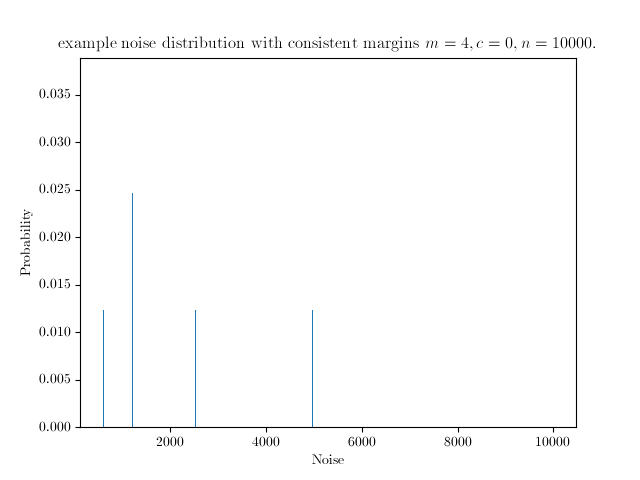

In [357]:
n = 10000
m = 4
c = 0
N_sols = 100000
db = gen_bin_data_set(n,m)
# print(len(margin_consistent_queries_ILP(db,c,m,n,N_sols)))
poss_counts = margin_consistent_queries_ILP(db,c,m,n,N_sols)
# lst = []
# for count in poss_counts:
#     lst.append(count[((),())])
# n_dict = dict((k,lst.count(k)/len(lst)) for k in list(set(lst)) )
# print(n_dict)
# print(len(poss_counts))
# N_sols = 1
# single_count = []
# for i in range(3000):
#     single_count.append(margin_consistent_queries_ILP(db,c,m,n,N_sols)[0][((),())])
# n_dict_samply = dict((k,single_count.count(k)/len(single_count)) for k in list(set(single_count)) )
# print(n_dict_samply) 


vals = []
for config in poss_counts:
    vals += list(config.values())

prob_dict = defaultdict()
for i in range(-c,c+1):
    prob_dict[i] = vals.count(i)/len(vals)

filename = f'fixed_marginal_probs/m_{m}_c_{c}.json'
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'w') as f: 
    json.dump(prob_dict, f)
    
print(prob_dict)
data = np.array(vals)

# d = np.diff(np.unique(data)).min()
# left_of_first_bin = data.min() - float(d)/2
# right_of_last_bin = data.max() + float(d)/2
# plt.figure()
# plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d),  density = True)
# plt.title(f'example noise distribution with consistent margins $m={m},c={c},n={n}$.')
# plt.ylabel('Probability')
# plt.xlabel('Noise')
# filename = f'small_count_plots/'
# os.makedirs(os.path.dirname(filename), exist_ok=True)
# plt.savefig(f'small_count_plots/small_n_Noise_comparison_consistent_margins_m_{m}_c_{c}_n_{n}.pdf') 
plt.show()
# plt.close()

In [377]:
cwd = os.getcwd()
cwd

'/Users/hmcarthur/differential_privacy/toy_model_ILP/margin_consistent'

In [376]:
def get_counts_prob_dict(db,quers,prob_dict,quer_seed_dict):
    """Returns noisy count of query, noise is generated according to discrete distribution represneted
    in prob dict. Will perturb negative counts to 0."""
    out_dict = defaultdict(int)
    for query in quers:
        out_dict[tuple(query)] = max(len(db.query(quer2string(query))) + quer2noise_prob_dict(query,quer_seed_dict,prob_dict),0)
        # print(np.random.randint(-noise,noise+1))
    return out_dict

def quer2noise_prob_dict(query,quer_seed_dict,prob_dict):
    """ generates noise from discrete-RV: U({-noise,noise})
    using the seed in the query dict"""
    # print(query)
    if quer_seed_dict != None:
        np.random.seed(quer_seed_dict[query])
    probs = np.array([x for x in prob_dict.values()])
    probs /= probs.sum()
    return int(np.random.choice([x for x in prob_dict.keys()], 1, p=probs))

def compare_marginal_prob_dict(c,n_sols,n,m,N_q_range):
    quer_seed_dict = None
    filename = f'fixed_marginal_probs/m_{m}_c_{c}.json'
    f = open(filename)
    prob_dict = json.load(f)
    # print(f'true margins underlying: {prob_dict}')
    
    db = gen_bin_data_set(n,m)
    db_tup = sorted([tuple(x) for x in list(db.to_numpy())],key=binatodeci)
    
    quers = gen_queries_comp(m)
    true_counts = get_counts_uniform(db,quers,0)
    true_counts[((),())] = n
    np.random.shuffle(quers)
    quers_prob_dict = get_counts_prob_dict(db,quers,prob_dict,quer_seed_dict)
    all_noise_dists = margin_consistent_queries_ILP(db,c,m,n,100000)
    quers_true_margins = all_noise_dists[int(np.random.randint(len(all_noise_dists)))]
    
    noises = [true_counts[k] - quers_true_margins[k] for k in quers]
    prob_dict_instance = defaultdict()
    for i in range(-c,c+1):
        prob_dict_instance[i] = noises.count(i)/len(noises)
    # print(f'true margins actual: {prob_dict_instance}')
    
    quers_prob_dict = get_counts_prob_dict(db,quers,prob_dict_instance,quer_seed_dict)
    
    noises = [true_counts[k] - quers_prob_dict[k] for k in quers]
    prob_dict_instance = defaultdict()
    for i in range(-c,c+1):
        prob_dict_instance[i] = noises.count(i)/len(noises)
    # print(f'random actual: {prob_dict_instance}')
    
    
    return_dict = defaultdict()
    
    for N_q_try in N_q_range:
        N_q = int(min(N_q_try,max_quers(m)))
        
        temp_dict = defaultdict()
        
        queries = quers[0:N_q]
        
        
        quer_dict_prob = dict((k, quers_prob_dict[k]) for k in queries)
        quer_dict_margins = dict((k, quers_true_margins[k]) for k in queries)
        # print(quer_dict_prob)
        # print(quer_dict_margins)
        
        partial_dict = defaultdict()
        
        for dist in ['prob','margins']:
            if dist == 'prob':
                sols_prob_ = gen_sols(n,m,quer_dict_prob,partial_dict,c,n_sols)
                sols = np.array(sols_prob_[0], dtype=int)
                time = sols_prob_[1]
            elif dist == 'margins':
                sols_margins_ = gen_sols(n,m,quer_dict_margins,partial_dict,c,n_sols)
                sols = np.array(sols_margins_[0], dtype=int)
                time = sols_margins_[1]
                
            backbone_size = 0
            if len(sols) < N_sols:
                fixed_sols = check_fixed_sols(sols)
                backbone_size = len(fixed_sols)/n

            row_sims = []
            tot_sims = []
#             counter_sols = []


#             sol_set = set()
#             for sol in sols:
#                 sol_tup = [tuple(x) for x in sol]
#                 sol_set.add(tuple(sol_tup))
#                 # print(sol_tup)
#                 counter_sols.append(Counter(list(sol_tup)))
#                 sol_tup, common = sol_tup[:], [ e for e in db_tup if e in sol_tup and (sol_tup.pop(sol_tup.index(e)) or True)]
#                 # tot_sims.append(ass_ILP(db_tup,sol_tup))
#                 row_sims.append(len(common)/n)

            # crit_query_count = 0
            # query_items = quer_dict.items()
            # for query in gen_crit_queries(db_tup,m,c):
            #     if query in query_items:
            #         crit_query_count += 1

            returns = {
                # 'maximum queries': max_quers(m),
                'backbone_size': backbone_size, 
                # 'tot_avg': np.mean(tot_sims), 
                # 'tot_min': np.min(tot_sims),
                # 'row_avg': np.mean(row_sims), 
                # 'row_min': np.min(row_sims), 
                'solve_time': time, 
                'N_sols_actual': len(sols),
                # "Contained": Counter(db_tup) in counter_sols,
                # "crit_queries": crit_query_count
            }
            # print(counter_sols)
            temp_dict[dist] = returns
        return_dict[N_q] = temp_dict
        
    return return_dict

def average_marginal_comp(c,n_sols,n,m,N_q_range,N_trials):
    """compares a noise dict with consistent marginals against another randomly
    generated noise dict on the same database, distributed in the same way as the 
    consistent marginals one"""
    
    out_lst = []
    for i in range(N_trials):
        temp_res = compare_marginal_prob_dict(c,n_sols,n,m,N_q_range)
        out_lst.append(temp_res)
    return ave(out_lst)


def ave(d):
    """given a list of nested dictionaries, it will return a dictionary of averages 
    in the same format as the individual dicts"""
    _data = sorted([i for b in d for i in b.items()], key=lambda x:x[0])
    _d = [(a, [j for _, j in b]) for a, b in groupby(_data, key=lambda x:x[0])]
    return {a:ave(b) if isinstance(b[0], dict) else sum(b)/float(len(b)) for a, b in _d}

# result = {'average':ave(list(data.values()))}

In [358]:
def margin_consistent_queries_ILP(db,c,m,n,N_sols):
    """ creates a dictionary of noisy counts based on database db with
    consistent margins"""

    all_quers = gen_queries_all(m)
    var_dict = defaultdict()
    true_counts = get_counts_uniform(db,all_quers,0)
    true_counts[((),())] = n
            
    M = gp.Model()
    M.Params.OutputFlag = 0
    
    # this is constraint for the empty query - i.e. noisy value of n
    var_dict[((),())] = M.addVar(vtype='I', name=f"((),())")
    M.addConstr(var_dict[((),())] >= 0 )
    M.addConstr(var_dict[((),())] >=  n - c)
    M.addConstr(var_dict[((),())] <=  n + c)
    
    for quer in all_quers:
        var_dict[quer] = M.addVar(vtype='I', name=f"{quer}")
        M.addConstr(var_dict[quer] >= 0 )
        M.addConstr(var_dict[quer] >=  true_counts[quer] - c)
        M.addConstr(var_dict[quer] <=  true_counts[quer] + c)
    
    marginal_constraints(M,var_dict,m)
    
    # Parameters
    M.Params.PoolSearchMode = 2
    M.Params.PoolSolutions = N_sols
    # m.Params.PoolSolutions = 2
    M.Params.PoolGap = 0.0

    # Optimize
    M.optimize()
    
    # print(f"Took {M.Runtime:.2f} seconds to solve")

    out_lst = []
    for k in range(M.SolCount):
        M.Params.SolutionNumber = k
        # var_dict_out = {x: var_dict[x].Xn - true_counts[x] for x in var_dict.keys()}
        var_dict_out = {x: var_dict[x].Xn for x in var_dict.keys()}
        # out_lst.append(n.Xn)
        out_lst.append(var_dict_out)
        
    return out_lst

def marginal_constraints(M,var_dict,m):
    """ Adds the constraints based on the queries in quer_dict"""
    
    for i in range(m)[::-1]:
        
        for quer in gen_quers(i,m):
            # print(quer)
            parts = gen_partitions_additional_attribute(quer,m)
            # print(parts)
            for part in parts:
                M.addConstr(var_dict[tuple(part[0])] + var_dict[tuple(part[1])] == var_dict[quer])
    return None

def gen_partitions_additional_attribute(query,m):
    """ returns a list of all the partitions of the query with one additional attribute"""
    other_atts = sorted(list(set(range(m)).difference(set(query[0]))))
    
    lst = []
    for i in other_atts:
        # print(i)
        # print(list(query[0]))
        quer_A = list(query[0])
        quer_A.append(i)
        quer_A = sorted(quer_A)
        
        lstt = []
        for j in [0,1]:
            quer_B = list(query[1])
            quer_B.insert(np.searchsorted(query[0],i),j)
            lstt.append((tuple(quer_A),tuple(quer_B)))
        lst.append(lstt)
    
    return lst

def gen_quers(k,m):
    """returns all the possible queries with k attributes, when considering m total attributes"""
    queries = []
    combs = itertools.combinations(range(m),k)
    for comb in combs:
        for choice in gen_powerset(k):
            quer = []
            quer.append(comb)
            quer.append(choice)
            queries.append(tuple(quer))
    return queries

    return None

In [380]:
c =1
m =4
n = 10
N_q_range = [30,40,50,60,70,80]
n_sols = 10000
N_trials = 20

# compare_marginal_prob_dict(c,n_sols,n,m,N_q_range)
data = average_marginal_comp(c,n_sols,n,m,N_q_range,N_trials)

params = f"c_{c}_n_{n}_m_{m}"



filename = f'experiment_data/{params}.json'
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'w') as f: 
    json.dump(data, f)

filename_params = f'experiment_data/{params}_params.json'
param_dict = {'n': int(n), 'm': int(m), 'c': int(c), 'N_q_range': N_q_range, 
                                               'N_sols': int(n_sols), 'N_trials': int(N_trials)}
os.makedirs(os.path.dirname(filename_params), exist_ok=True)
with open(filename_params, 'w') as f: 
    json.dump(param_dict, f)

{'n': 10, 'm': 4, 'c': 1, 'N_q_range': [30, 40, 50, 60, 70, 80], 'N_sols': 10000, 'N_trials': 20}


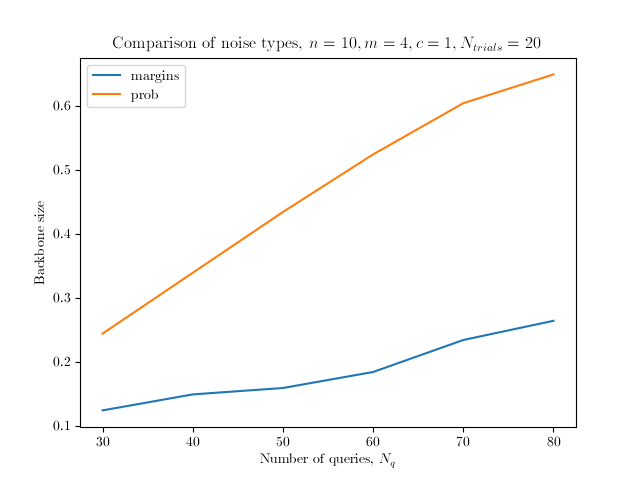

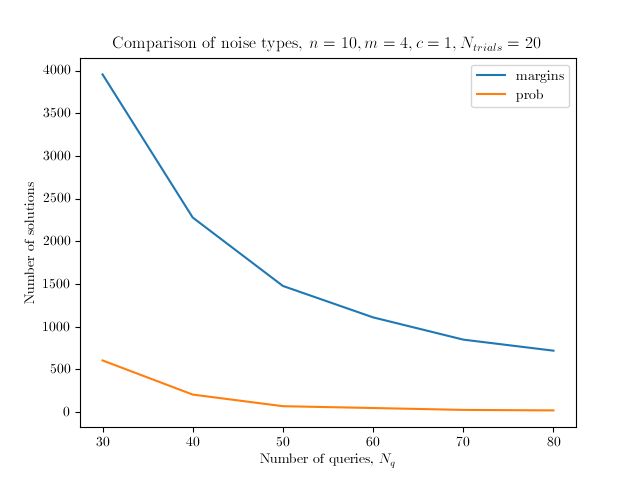

In [397]:
filename = 'experiment_data/c_1_n_10_m_4.json'
data = pd.read_json(filename)
filename_params = 'experiment_data/c_1_n_10_m_4_params.json'
f = open(filename_params)
data_params = json.load(f)
print(data_params)

for feature in ['backbone_size','N_sols_actual']:    
    heading_dict = {'backbone_size': 'Backbone size', 'tot_avg': 'Total similarity',
                    'row_avg': "Row Similarity", 'N_sols_actual': "Number of solutions"}
    
    # plt.clf() 
    plt.figure()
    x = data.keys()
    keys = data[x[0]].keys()
    
    for key in keys:
        y = [data[i][key][feature] for i in x]
        plt.plot(x, y, label = f'{key}')
    
    plt.xlabel('Number of queries, $N_q$')
    plt.ylabel(f'{heading_dict[feature]}')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.title(f"Comparison of noise types, $n={data_params['n']}, \
              m={data_params['m']},c={data_params['c']},N_{{trials}}={data_params['N_trials']}$")
    # plt.title(f'{heading_dict[feature]} for varying $c, m=5, n=30, N_{{trials}} =30$')
    # plt.title(f"$c$")
    # plt.ylim([0,105])
    plt.legend()
    plt.savefig(f'figures/margin_comp_{feature}.pdf') 
    plt.show()
    # plt.close()